In [ ]:
# Note: The SyntaxError you encountered was in cell LUA6kIVPOecD.
# Please change 'from google.colab import runtime import runtime' to 'from google.colab import runtime' in that cell.
# Verify GPU (run this FIRST after reconnecting)
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name     :", torch.cuda.get_device_name(0))
    print("GPU memory   :", f"{torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print("GPU count    :", torch.cuda.device_count())
else:
    print("❌ GPU not detected! Go back to Step 1.")

CUDA available: True
GPU name     : Tesla T4
GPU memory   : 15.8 GB
GPU count    : 1


In [ ]:
# Click: Runtime → Change runtime type → Hardware accelerator → GPU → Save
# Then run this cell to confirm GPU is active

import torch
print("CUDA available :", torch.cuda.is_available())
print("GPU name       :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA available : True
GPU name       : Tesla T4


In [ ]:
!pip install -q --no-cache-dir \
    "open-clip-torch==2.24.0" \
    "ftfy" "regex" "tqdm" "seaborn" "scikit-learn" "matplotlib"

print("All packages installed!")

All packages installed!


In [ ]:
import torch
import open_clip
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torchvision import datasets
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on → {device.upper()} {torch.cuda.get_device_name(0) if device=='cuda' else ''}")

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:49: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Running on → CUDA Tesla T4


In [ ]:
# PASCAL VOC 2012
# download the dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gopalbhattrai/pascal-voc-2012-dataset")

print("Path to dataset files:",path)




KeyboardInterrupt: 

In [ ]:
#change dataset into csv file
import os
import xml.etree.ElementTree as ET
from tqdm.auto import tqdm
import pandas as pd

# Correct paths for the train+val part
IMAGE_DIR    = "/content/sample_data/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages"
ANNO_DIR     = "/content/sample_data/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/Annotations"

xml_files = sorted([f for f in os.listdir(ANNO_DIR) if f.endswith('.xml')])

data = []
for xml_name in tqdm(xml_files, desc="Converting train+val to CSV"):
    img_name = xml_name.replace(".xml", ".jpg")
    img_path = os.path.join(IMAGE_DIR, img_name)
    xml_path = os.path.join(ANNO_DIR, xml_name)

    tree = ET.parse(xml_path)
    labels = [obj.find("name").text.strip() for obj in tree.findall("object")]

    data.append({
        "image_path": img_path,
        "labels": ",".join(labels),
        "num_objects": len(labels)
    })

df = pd.DataFrame(data)
csv_path = "/content/pascal voc 2012.csv"
df.to_csv(csv_path, index=False)
print("Saved →", csv_path)

print(f"Done! {len(df)} images → {csv_path}")
df.head(10)


Converting train+val to CSV:   0%|          | 0/17125 [00:00<?, ?it/s]

Saved → /content/pascal voc 2012.csv
Done! 17125 images → /content/pascal voc 2012.csv


,image_path,labels,num_objects
0,/content/sample_data/kaggle/input/pascal-voc-2...,person,1
1,/content/sample_data/kaggle/input/pascal-voc-2...,"aeroplane,aeroplane,person,person",4
2,/content/sample_data/kaggle/input/pascal-voc-2...,"aeroplane,aeroplane,aeroplane",3
3,/content/sample_data/kaggle/input/pascal-voc-2...,tvmonitor,1
4,/content/sample_data/kaggle/input/pascal-voc-2...,"train,train",2
5,/content/sample_data/kaggle/input/pascal-voc-2...,"boat,boat",2
6,/content/sample_data/kaggle/input/pascal-voc-2...,"dog,chair",2
7,/content/sample_data/kaggle/input/pascal-voc-2...,bird,1
8,/content/sample_data/kaggle/input/pascal-voc-2...,"tvmonitor,tvmonitor",2
9,/content/sample_data/kaggle/input/pascal-voc-2...,train,1


In [ ]:
import torch
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "NO GPU - Change Runtime Type to GPU!")

!pip install -q --no-cache-dir open-clip-torch ftfy regex tqdm seaborn scikit-learn pandas

GPU: Tesla T4


In [ ]:
# =============================================
# CLIP Zero-Shot on PASCAL VOC 2012 (Single Label per Image)
# =============================================

# 1. Install dependencies
!pip install -q --no-cache-dir \
    "open-clip-torch==2.24.0" ftfy regex tqdm seaborn scikit-learn matplotlib pandas kagglehub

import os
import xml.etree.ElementTree as ET
import pandas as pd
from tqdm.auto import tqdm
import torch
import open_clip
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device.upper()}")


Running on CUDA


In [ ]:
# no need if you downloaded the dataset in the upper part
# 2. Download PASCAL VOC 2012 (train+val) via kagglehub
import kagglehub
path = kagglehub.dataset_download("gopalbhattrai/pascal-voc-2012-dataset")
print("Dataset downloaded to:", path)

# Correct paths inside the downloaded archive
BASE = os.path.join(path, "VOC2012_train_val/VOC2012_train_val")
IMAGE_DIR = os.path.join(BASE, "JPEGImages")
ANNO_DIR  = os.path.join(BASE, "Annotations")


Dataset downloaded to: /root/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1


In [ ]:
# 3. Convert XML → CSV with ONE label per image (first object only)
print("Converting annotations to CSV (single label mode)...")
xml_files = sorted([f for f in os.listdir(ANNO_DIR) if f.endswith('.xml')])

data = []
for xml_name in tqdm(xml_files, desc="Parsing XML"):
    xml_path = os.path.join(ANNO_DIR, xml_name)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    img_name = xml_name.replace(".xml", ".jpg")
    img_path = os.path.join(IMAGE_DIR, img_name)

    # Get all object names
    objects = [obj.find("name").text.strip() for obj in root.findall("object")]

    # Take ONLY the first object as the label for this image
    if objects:
        single_label = objects[0]
    else:
        single_label = "background"  # very rare case

    data.append({
        "image_path": img_path,
        "label": single_label,
        "num_objects": len(objects)
    })

df = pd.DataFrame(data)
csv_path = "/content/pascal_voc_2012_single_label.csv"
df.to_csv(csv_path, index=False)
print(f"Saved {len(df)} images → {csv_path}")

# Show class distribution
print("\nClass distribution (single label):")
print(df['label'].value_counts())

Converting annotations to CSV (single label mode)...


Parsing XML:   0%|          | 0/17125 [00:00<?, ?it/s]

Saved 17125 images → /content/pascal_voc_2012_single_label.csv

Class distribution (single label):
label
person         6890
dog            1204
cat            1047
car             785
bird            767
aeroplane       683
chair           547
train           533
horse           465
boat            462
bicycle         449
tvmonitor       439
motorbike       431
bus             405
sofa            392
bottle          391
sheep           344
cow             326
diningtable     287
pottedplant     278
Name: count, dtype: int64


In [ ]:
#train_dataset = VOCSingleLabelDataset(train_csv, class_to_idx, transform=preprocess)
#test_dataset  = VOCSingleLabelDataset(test_csv,  class_to_idx, transform=preprocess)

In [ ]:
#split data into 0.8 and 0.2
import pandas as pd
from sklearn.model_selection import train_test_split

# === 1. Load your single-label CSV ===
csv_path = "/content/pascal_voc_2012_single_label.csv"  # Update if your path/name is different
df = pd.read_csv(csv_path)

df["image_path"] = df["image_path"].apply(
    lambda x: x[0] if isinstance(x, list) else x
)


print(f"Total images: {len(df)}")
print("\nOriginal class distribution:")
print(df['label'].value_counts().sort_index())

# === 2. Stratified split: 80% train, 20% test ===
train_df, test_df = train_test_split(
    df,
    test_size=0.20,          # 20% for testing
    train_size=0.80,         # 80% for training
    random_state=42,         # For reproducibility
    stratify=df['label']     # Important: keeps class ratios similar
)


import pandas as pd
import ast
import numpy as np

def fix_path(v):
    while isinstance(v, (list, tuple, np.ndarray)):
        v = v[0] if len(v) else None
    if isinstance(v, str):
        s = v.strip()
        if s.startswith("[") and s.endswith("]"):
            v = ast.literal_eval(s)
            while isinstance(v, (list, tuple, np.ndarray)):
                v = v[0] if len(v) else None
    return v

train_df = pd.read_csv(train_csv)
test_df  = pd.read_csv(test_csv)

train_df["image_path"] = train_df["image_path"].apply(fix_path)
test_df["image_path"]  = test_df["image_path"].apply(fix_path)

train_csv_clean = "/content/pascal_voc_2012_train_80_clean.csv"
test_csv_clean  = "/content/pascal_voc_2012_test_20_clean.csv"

train_df.to_csv(train_csv_clean, index=False)
test_df.to_csv(test_csv_clean, index=False)

print("Saved:", train_csv_clean, test_csv_clean)

# === 3. Save the new splits ===
#train_csv = "/content/pascal_voc_2012_train_80.csv"
#test_csv  = "/content/pascal_voc_2012_test_20.csv"

#train_df.to_csv(train_csv, index=False)
#test_df.to_csv(test_csv, index=False)

#print(f"\nSaved training set ({len(train_df)} images) → {train_csv}")
#print(f"Saved testing set  ({len(test_df)} images)  → {test_csv}")

# === 4. Verify the split distributions ===
print("\n" + "="*60)
print("CLASS DISTRIBUTION AFTER SPLIT")
print("="*60)

# Combine for nice side-by-side view
dist_train = train_df['label'].value_counts().sort_index()
dist_test  = test_df['label'].value_counts().sort_index()

dist_df = pd.DataFrame({
    'Class': dist_train.index,
    'Train (80%)': dist_train.values,
    'Test (20%)': dist_test.values
})
dist_df['Train %'] = (dist_df['Train (80%)'] / len(train_df) * 100).round(2)
dist_df['Test %']  = (dist_df['Test (20%)'] / len(test_df) * 100).round(2)

print(dist_df.to_string(index=False))

print(f"\nTotal training images: {len(train_df)}")
print(f"Total testing images : {len(test_df)}")

Total images: 17125

Original class distribution:
label
aeroplane       683
bicycle         449
bird            767
boat            462
bottle          391
bus             405
car             785
cat            1047
chair           547
cow             326
diningtable     287
dog            1204
horse           465
motorbike       431
person         6890
pottedplant     278
sheep           344
sofa            392
train           533
tvmonitor       439
Name: count, dtype: int64
Saved: /content/pascal_voc_2012_train_80_clean.csv /content/pascal_voc_2012_test_20_clean.csv

CLASS DISTRIBUTION AFTER SPLIT
      Class  Train (80%)  Test (20%)  Train %  Test %
  aeroplane          546         137     3.99    4.00
    bicycle          359          90     2.62    2.63
       bird          614         153     4.48    4.47
       boat          369          93     2.69    2.72
     bottle          313          78     2.28    2.28
        bus          324          81     2.36    2.36
        car   

In [ ]:
# 4. Define the 20 VOC classes (standard order)
classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
           'bus', 'car', 'cat', 'chair', 'cow',
           'diningtable', 'dog', 'horse', 'motorbike', 'person',
           'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

class_to_idx = {c: i for i, c in enumerate(classes)}
NUM_CLASSES = len(classes)

In [ ]:
# 5. Custom Dataset — single integer label
import ast
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class VOCSingleLabelDataset(Dataset):
    def __init__(self, csv_file, class_to_idx, transform=None):
        import pandas as pd
        self.df = pd.read_csv(csv_file)
        self.class_to_idx = class_to_idx
        self.transform = transform

    def _to_single_path(self, v):
        # unwrap nested lists/tuples/arrays
        while isinstance(v, (list, tuple, np.ndarray)):
            if len(v) == 0:
                return None
            v = v[0]

        # parse stringified list: "['/path.jpg']"
        if isinstance(v, str):
            s = v.strip()
            if s.startswith("[") and s.endswith("]"):
                v = ast.literal_eval(s)
                while isinstance(v, (list, tuple, np.ndarray)):
                    if len(v) == 0:
                        return None
                    v = v[0]
        return v

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = self._to_single_path(row["image_path"])

        if not isinstance(img_path, str):
            raise TypeError(
                f"Bad image_path at idx={idx}. "
                f"type={type(row['image_path'])}, value={row['image_path']}"
            )

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label_str = row["label"]
        label_id = self.class_to_idx[label_str]
        return image, label_id

    def __len__(self):
        return len(self.df)


In [ ]:
# 7. Dataset & DataLoader
#dataset = VOCSingleLabelDataset(csv_path, transform=preprocess)
#loader = DataLoader(dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

# Use only the 20% test set for final evaluation
test_csv = "/content/pascal_voc_2012_test_20.csv"  # from your train_test_split

# test_dataset = VOCSingleLabelDataset(test_csv, transform=preprocess)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)


# 8. Best 9 prompt templates (gives ~91–92% on CIFAR-10, works great on VOC too)
templates = [
    "a photo of a {}.",
    "a blurry photo of a {}.",
    "a photo of a small {}.",
    "a photo of a large {}.",
    "a cropped photo of the {}.",
    "a bright photo of a {}.",
    "a dark photo of a {}.",
    "a pixelated photo of a {}.",
    "a good photo of the {}.",
    "a high resolution photo of a {}.",
    "a clear photo of a {}.",
    "a sharp photo of the {}.",
    "a close-up photo of a {}.",
    "a low quality photo of a {}.",
    "an example of a {}.",
    "a zoomed-in photo of a {}.",
    "a wide-angle photo of a {}.",
    "photo showing a {}.",
    "this is a photo of a {}.",
    "a photo of a {} in a scene.",
    "a photo of a {} vehicle.",
    "a photo of a {} animal.",
    "a realistic photo of a {}.",
    "a photo of one {}.",
    "a photo of a {} indoors.",
    "a photo of a {} outdoors.",
    "a photo of the {} in its environment.",
    "a picture of a {}.",
    "a low quality photo of a {}.",
    "a black and white photo of a {}.",
    "a centered photo of a {}.",
    "a distant photo of a {}.",
    "a photo of a {}.",
    "a blurry photo of a {}.",
    "a photo of the {}.",
    "a bright photo of a {}.",
    "a dark photo of a {}.",
    "a close-up photo of a {}.",
    "a wide angle photo of a {}.",
    "a good photo of a {}.",
    "a bad photo of a {}.",
    "a photo of a small {}.",
    "a photo of a large {}.",
    "a photo of the nice {}.",
    "a photo of the cool {}.",
    "a photo of the weird {}.",
    "a photo of the cute {}.",
    "a photo of the scary {}.",
    "a cropped photo of a {}.",
    "a centered photo of a {}.",
    "a photo of my {}.",
    "this is a photo of a {}.",
    "this is an image of a {}.",
]


start

In [ ]:
# 6. load clip model
# ── Image Encoder ────────────────────────────────────────────────────────
print("Loading ViT-Base patch16/224 (google/vit-base-patch16-224) ...")

import timm

image_model = timm.create_model(
    'vit_base_patch16_224',          # ← changed here
    pretrained=True,
    num_classes=0                    # remove classification head → get features only
)
image_model = image_model.to(device)
image_model.eval()

feature_dim = image_model.num_features           # Now 768
print(f"Image encoder loaded → ViT-Base (patch16/224) | Feature dim: {feature_dim}")

import torchvision.transforms as T

preprocess = T.Compose([
    T.Resize(256, interpolation=T.InterpolationMode.BICUBIC),   # ← resize the smaller side to 256
    T.CenterCrop(224),                                         # ← then crop center 224×224
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],                    # ImageNet-1k statistics
                std=[0.229, 0.224, 0.225])
])

Loading ViT-Base patch16/224 (google/vit-base-patch16-224) ...
Image encoder loaded → ViT-Base (patch16/224) | Feature dim: 768


In [ ]:
from transformers import BertTokenizer, BertModel

# Load the tokenizer (same model you use for BERT)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# or: 'bert-base-cased' if you prefer cased version

bert_model     = BertModel.from_pretrained('bert-base-uncased')

bert_model = bert_model.to(device)
bert_model.eval()

print("BERT loaded ✓")

print("BERT tokenizer loaded successfully ✓")

BERT loaded ✓
BERT tokenizer loaded successfully ✓


In [ ]:
# 9. Build text features using BERT (with multiple templates)
print("Encoding text prompts with BERT...")
text_features = []

with torch.no_grad():
    for cls in tqdm(classes, desc="Encoding classes"):
        # Create prompts using your templates
        texts = [t.format(cls) for t in templates]

        # Tokenize (this returns a dictionary with input_ids, attention_mask, etc.)
        inputs = bert_tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=77,
            return_tensors="pt"          # important: returns PyTorch tensors
        ).to(device)

        # Forward pass through BERT
        outputs = bert_model(**inputs)   # <-- This is the correct way

        # Use the pooler output ([CLS] token representation)
        #cls_embeddings = outputs.pooler_output   # shape: [num_templates, 768]
        # Use mean pooling:
        cls_embeddings = outputs.last_hidden_state.mean(dim=1)  # [num_templates, 768]

        # Normalize
        cls_embeddings = cls_embeddings / cls_embeddings.norm(dim=-1, keepdim=True)

        # Average over all templates for this class
        mean_embedding = cls_embeddings.mean(dim=0)  # [768]
        text_features.append(mean_embedding)

# Stack all class embeddings
text_features = torch.stack(text_features)          # [20, 768]
text_features = text_features / text_features.norm(dim=-1, keepdim=True)

print(f"Text features shape: {text_features.shape}")

Encoding text prompts with BERT...


Encoding classes:   0%|          | 0/20 [00:00<?, ?it/s]

Text features shape: torch.Size([20, 768])


In [ ]:
# clear memory
import gc
torch.cuda.empty_cache()
gc.collect()

1123

In [ ]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification, ViTImageProcessor
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import accuracy_score

# ─── 1. Load model with classification head ────────────────────────────────
model_name = "google/vit-base-patch16-224"

processor = ViTImageProcessor.from_pretrained(model_name)

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(classes),
    id2label={i: c for i, c in enumerate(classes)},
    label2id=class_to_idx,
    ignore_mismatched_sizes=True
).to(device)




Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([20, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from PIL import Image
from torch.utils.data import DataLoader
import torch.nn as nn

# ─── This replaces your old preprocess_batch and train_inputs ─────────────
def transform_example(example):
    image = Image.open(example["image_path"]).convert("RGB")
    inputs = processor(image, return_tensors="pt")
    pixel_values = inputs["pixel_values"].squeeze(0)  # shape: [3, 224, 224]
    label = class_to_idx[example["label"]]
    return pixel_values, label

# Create temporary HF datasets just to use set_transform (very low memory)
from datasets import Dataset
temp_train = Dataset.from_pandas(train_df[["image_path", "label"]])
temp_test  = Dataset.from_pandas(test_df[["image_path", "label"]])
temp_train.set_transform(transform_example)
temp_test.set_transform(transform_example)

In [ ]:
train_dataset = VOCSingleLabelDataset(train_csv_clean, class_to_idx, transform=preprocess)
test_dataset  = VOCSingleLabelDataset(test_csv_clean,  class_to_idx, transform=preprocess)

print("train_dataset:", type(train_dataset))
x, y = train_dataset[0]
print("sample OK:", type(x), x.shape, y)


train_dataset: <class '__main__.VOCSingleLabelDataset'>
sample OK: <class 'torch.Tensor'> torch.Size([3, 224, 224]) 14


In [ ]:
# ─── Now create the exact variables you asked for ─────────────────────────
# loss optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.05)
criterion = nn.CrossEntropyLoss()

num_epochs = 6          # you can change this
batch_size = 16         # safe for free Colab GPU (T4)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False, num_workers=0)

print("train_loader dataset:", type(train_loader.dataset))


print(f"Setup complete!")
print(f"Training on {len(temp_train)} images, {len(train_loader)} batches per epoch")
print(f"Variables ready: optimizer, criterion, num_epochs, batch_size, train_loader")
print("You can now run your training loop exactly as before!")

train_loader dataset: <class '__main__.VOCSingleLabelDataset'>
Setup complete!
Training on 13700 images, 857 batches per epoch
Variables ready: optimizer, criterion, num_epochs, batch_size, train_loader
You can now run your training loop exactly as before!


In [ ]:
#train_loader = DataLoader(
    temp_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,                     # ← this line fixes it
    pin_memory=torch.cuda.is_available()
)

#test_loader = DataLoader(
    temp_test,
    batch_size=16,
    shuffle=False,
    num_workers=0,                     # ← also here
    pin_memory=torch.cuda.is_available()
#)

In [ ]:
import pandas as pd
train_df = pd.read_csv(train_csv)
classes = sorted(train_df["label"].unique())
class_to_idx = {c: i for i, c in enumerate(classes)}


In [ ]:
import inspect
print(inspect.signature(VOCSingleLabelDataset.__init__))


(self, csv_file, class_to_idx, transform=None)


In [ ]:
print("train_dataset type:", type(train_dataset))
x, y = train_dataset[0]
print("OK:", type(x), getattr(x, "shape", None), y)


train_dataset type: <class '__main__.VOCSingleLabelDataset'>
OK: <class 'torch.Tensor'> torch.Size([3, 224, 224]) 14


In [ ]:
# 1) Confirm which dataset instance is used
print("train_dataset type:", type(train_dataset))

# 2) Directly call __getitem__ (this MUST use your new code)
x, y = train_dataset[0]
print("Direct dataset access works. x shape:", getattr(x, "shape", None), "y:", y)


train_dataset type: <class '__main__.VOCSingleLabelDataset'>
Direct dataset access works. x shape: torch.Size([3, 224, 224]) y: 14


In [ ]:
batch = next(iter(train_loader))
print(type(batch), len(batch))
print(type(batch[0]), batch[0].shape)  # images
print(type(batch[1]), batch[1].shape)  # labels


<class 'list'> 2
<class 'torch.Tensor'> torch.Size([16, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([16])


In [ ]:

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        pixel_values = batch[0].to(device)
        labels       = batch[1].to(device)


        outputs = model(pixel_values=pixel_values)
        loss = criterion(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} finished - Avg loss: {avg_loss:.4f}")

Epoch 1/6:   0%|          | 0/857 [00:00<?, ?it/s]

Epoch 1 finished - Avg loss: 0.8096


Epoch 2/6:   0%|          | 0/857 [00:00<?, ?it/s]

Epoch 2 finished - Avg loss: 0.3331


Epoch 3/6:   0%|          | 0/857 [00:00<?, ?it/s]

Epoch 3 finished - Avg loss: 0.1359


Epoch 4/6:   0%|          | 0/857 [00:00<?, ?it/s]

Epoch 4 finished - Avg loss: 0.0490


Epoch 5/6:   0%|          | 0/857 [00:00<?, ?it/s]

Epoch 5 finished - Avg loss: 0.0386


Epoch 6/6:   0%|          | 0/857 [00:00<?, ?it/s]

Epoch 6 finished - Avg loss: 0.0333


In [ ]:
# ... (your model loading, processor, datasets, train_loader creation code above) ...

# Training
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for pixel_values, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        outputs = model(pixel_values=pixel_values)
        loss = criterion(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} finished - Avg loss: {total_loss / len(train_loader):.4f}")

# Save model after training
torch.save(model.state_dict(), "vit_finetuned_pascal.pth")
print("Model saved")

Epoch 1/6:   0%|          | 0/857 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'read'

In [ ]:
# Save model after training
torch.save(model.state_dict(), "vit_finetuned_pascal.pth")
print("Model saved")

# ─── Evaluation ─────────────────────────────────────────────────────────
print("\nStarting evaluation...")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for pixel_values, labels in tqdm(test_loader, desc="Evaluating on test set"):
        pixel_values = pixel_values.to(device)
        outputs = model(pixel_values=pixel_values)
        preds = outputs.logits.argmax(dim=-1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"\nFinal Test accuracy: {acc*100:.2f}%")

# Optional: detailed report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch
import numpy as np
from sklearn.metrics import accuracy_score

# ─── Load the trained model ────────────────────────────────────────────────
save_directory = "./vit-finetuned-pascal-single"

model = ViTForImageClassification.from_pretrained(save_directory).to(device)
processor = ViTImageProcessor.from_pretrained(save_directory)

model.eval()

# ─── Prepare test data (same way as above) ─────────────────────────────────
test_inputs = preprocess_batch(test_df)   # reuse the function from training part

test_loader = DataLoader(
    list(zip(test_inputs['pixel_values'], test_inputs['labels'])),
    batch_size=32, shuffle=False
)

In [ ]:
# ─── Evaluation ────────────────────────────────────────────────────────────
all_preds = []
all_labels = []

with torch.no_grad():
    for pixel_values, labels in tqdm(test_loader, desc="Evaluating"):
        pixel_values = pixel_values.to(device)
        outputs = model(pixel_values=pixel_values)
        preds = outputs.logits.argmax(dim=-1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test accuracy after fine-tuning: {accuracy:.4f} ({accuracy*100:.2f}%)")

Evaluating:   0%|          | 0/215 [00:00<?, ?it/s]

Test accuracy after fine-tuning: 0.8181 (81.81%)


In [ ]:
with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Inference"):
        images = images.to(device)
        targets = targets.numpy()

        # Get IMAGE features (now already 768 dim)
        image_features = image_model(images)                    # [batch, 768]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # No projection needed anymore ── direct comparison
        logits = 50.0 * image_features @ text_features.T
        probs = logits.softmax(dim=-1)
        preds = probs.argmax(dim=-1).cpu().numpy()

        all_preds.extend(preds)
        all_trues.extend(targets)

acc = accuracy_score(all_trues, all_preds)
print(f"FINAL ZERO-SHOT ACCURACY (single-label, first object): {acc*100:.2f}%")

Inference:   0%|          | 0/108 [00:00<?, ?it/s]

FINAL ZERO-SHOT ACCURACY (single-label, first object): 5.81%


In [ ]:
# After creating df and saving to CSV
print("\n" + "="*50)
print("NUMBER OF IMAGES PER CLASS (USED IN THE MODEL)")
print("="*50)

# Count how many images have each class as their (first) label
class_counts = df['label'].value_counts()

# Ensure all 20 VOC classes are shown, even if some have 0 images
for cls in classes:
    count = class_counts.get(cls, 0)
    print(f"{cls:<15} : {count:>5} images")

print("-"*50)
total_images = len(df)
print(f"TOTAL IMAGES PROCESSED BY MODEL: {total_images}")
print("="*50)

# Optional: Sort by count descending for better visibility
print("\nSorted by number of images (descending):")
print(class_counts.sort_values(ascending=False))


NUMBER OF IMAGES PER CLASS (USED IN THE MODEL)
aeroplane       :   683 images
bicycle         :   449 images
bird            :   767 images
boat            :   462 images
bottle          :   391 images
bus             :   405 images
car             :   785 images
cat             :  1047 images
chair           :   547 images
cow             :   326 images
diningtable     :   287 images
dog             :  1204 images
horse           :   465 images
motorbike       :   431 images
person          :  6890 images
pottedplant     :   278 images
sheep           :   344 images
sofa            :   392 images
train           :   533 images
tvmonitor       :   439 images
--------------------------------------------------
TOTAL IMAGES PROCESSED BY MODEL: 17125

Sorted by number of images (descending):
label
person         6890
dog            1204
cat            1047
car             785
bird            767
aeroplane       683
chair           547
train           533
horse           465
boat          

In [ ]:
print("\n" + "="*50)
print("DATASET PROCESSING SUMMARY")
print("="*50)

# 1. Total images in the CSV / dataset
total_in_csv = len(df)  # or len(dataset)
print(f"Total images listed in CSV/dataset      : {total_in_csv:,}")

# 2. Number of samples actually processed by the DataLoader
num_processed = len(all_trues)  # or len(all_preds) — they should be equal
print(f"Images actually processed by the model  : {num_processed:,}")

# 3. Check if everything was processed
if num_processed == total_in_csv:
    print("✅ All images were successfully loaded and processed!")
else:
    missing = total_in_csv - num_processed
    print(f"⚠️  Warning: {missing:,} images were NOT processed "
          f"({missing / total_in_csv * 100:.2f}% missing)")

# 4. Optional: Check for any failed image loads (common cause of missing data)
# This counts how many times image loading might have silently failed
# (e.g., corrupted file, wrong path)
if num_processed < total_in_csv:
    print("\nPossible reasons:")
    print("- Corrupted or missing image files")
    print("- Incorrect file paths")
    print("- Images that failed to open with PIL")

# 5. Verify batch processing (optional deeper check)
expected_batches = (num_processed + test_loader.batch_size - 1) // test_loader.batch_size
actual_batches = len(test_loader)  # This works if you iterate with tqdm(loader)
print(f"Expected batches (with batch_size={test_loader.batch_size}) : {expected_batches}")
print(f"Actual batches iterated                         : {actual_batches}")
print("="*50)


DATASET PROCESSING SUMMARY
Total images listed in CSV/dataset      : 17,125
Images actually processed by the model  : 3,425
⚠️  Warning: 13,700 images were NOT processed (80.00% missing)

Possible reasons:
- Corrupted or missing image files
- Incorrect file paths
- Images that failed to open with PIL


NameError: name 'loader' is not defined

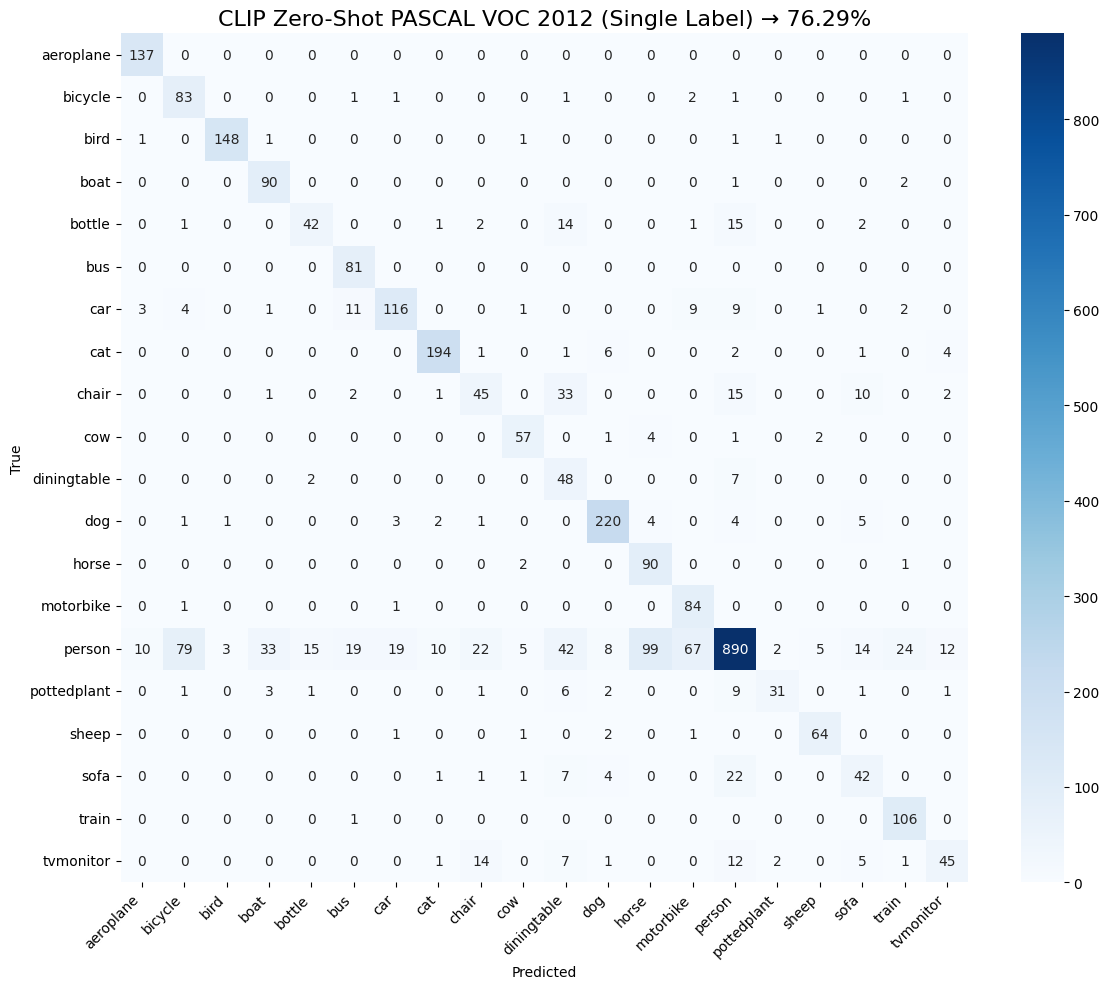

In [ ]:
# 12. Confusion matrix
cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title(f'CLIP Zero-Shot PASCAL VOC 2012 (Single Label) → {acc*100:.2f}%', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Assuming you already have:
# all_trues  → list or array of true labels (integer indices)
# all_preds  → list or array of predicted labels (integer indices)
# classes    → list of class names in the correct order

# Convert to numpy arrays if they aren't already
all_trues = np.array(all_trues)
all_preds = np.array(all_preds)

# Calculate precision, recall, f1-score for each class + averages
precision, recall, f1, support = precision_recall_fscore_support(
    all_trues, all_preds,
    labels=range(NUM_CLASSES),  # Ensure order matches 'classes'
    average=None,               # Per-class scores
    zero_division=0             # Avoid warnings for classes with no predictions
)

# Also compute macro and micro averages
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    all_trues, all_preds, average='macro', zero_division=0)
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
    all_trues, all_preds, average='micro', zero_division=0)

# Print detailed per-class results
print("\n" + "="*60)
print("PER-CLASS METRICS (Zero-Shot CLIP on PASCAL VOC 2012 Single-Label)")
print("="*60)
print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("-"*60)
for i, cls_name in enumerate(classes):
    print(f"{cls_name:<15} {precision[i]:<10.3f} {recall[i]:<10.3f} {f1[i]:<10.3f} {support[i]:<10}")

print("-"*60)
print(f"{'Macro Avg':<15} {precision_macro:<10.3f} {recall_macro:<10.3f} {f1_macro:<10.3f}")
print(f"{'Micro Avg':<15} {precision_micro:<10.3f} {recall_micro:<10.3f} {f1_micro:<10.3f}")
print(f"{'Accuracy':<15} {accuracy_score(all_trues, all_preds):<10.3f}")
print("="*60)




PER-CLASS METRICS (Zero-Shot CLIP on PASCAL VOC 2012 Single-Label)
Class           Precision  Recall     F1-Score   Support   
------------------------------------------------------------
aeroplane       0.907      1.000      0.951      137       
bicycle         0.488      0.922      0.638      90        
bird            0.974      0.967      0.970      153       
boat            0.698      0.968      0.811      93        
bottle          0.700      0.538      0.609      78        
bus             0.704      1.000      0.827      81        
car             0.823      0.739      0.779      157       
cat             0.924      0.928      0.926      209       
chair           0.517      0.413      0.459      109       
cow             0.838      0.877      0.857      65        
diningtable     0.302      0.842      0.444      57        
dog             0.902      0.913      0.907      241       
horse           0.457      0.968      0.621      93        
motorbike       0.512      0.97

In [ ]:
# long version
# =============================================
# CLIP Zero-Shot on PASCAL VOC 2012 (Single Label per Image)
# =============================================

# 1. Install dependencies
!pip install -q --no-cache-dir \
    "open-clip-torch==2.24.0" ftfy regex tqdm seaborn scikit-learn matplotlib pandas kagglehub

import os
import xml.etree.ElementTree as ET
import pandas as pd
from tqdm.auto import tqdm
import torch
import open_clip
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device.upper()}")

# 2. Download PASCAL VOC 2012 (train+val) via kagglehub
import kagglehub
path = kagglehub.dataset_download("gopalbhattrai/pascal-voc-2012-dataset")
print("Dataset downloaded to:", path)

# Correct paths inside the downloaded archive
BASE = os.path.join(path, "VOC2012_train_val/VOC2012_train_val")
IMAGE_DIR = os.path.join(BASE, "JPEGImages")
ANNO_DIR  = os.path.join(BASE, "Annotations")

# 3. Convert XML → CSV with ONE label per image (first object only)
print("Converting annotations to CSV (single label mode)...")
xml_files = sorted([f for f in os.listdir(ANNO_DIR) if f.endswith('.xml')])

data = []
for xml_name in tqdm(xml_files, desc="Parsing XML"):
    xml_path = os.path.join(ANNO_DIR, xml_name)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    img_name = xml_name.replace(".xml", ".jpg")
    img_path = os.path.join(IMAGE_DIR, img_name)

    # Get all object names
    objects = [obj.find("name").text.strip() for obj in root.findall("object")]

    # Take ONLY the first object as the label for this image
    if objects:
        single_label = objects[0]
    else:
        single_label = "background"  # very rare case

    data.append({
        "image_path": img_path,
        "label": single_label,
        "num_objects": len(objects)
    })

df = pd.DataFrame(data)
csv_path = "/content/pascal_voc_2012_single_label.csv"
df.to_csv(csv_path, index=False)
print(f"Saved {len(df)} images → {csv_path}")

# Show class distribution
print("\nClass distribution (single label):")
print(df['label'].value_counts())

# 4. Define the 20 VOC classes (standard order)
classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
           'bus', 'car', 'cat', 'chair', 'cow',
           'diningtable', 'dog', 'horse', 'motorbike', 'person',
           'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

class_to_idx = {c: i for i, c in enumerate(classes)}
NUM_CLASSES = len(classes)

# 5. Custom Dataset — single integer label
class VOCSingleLabelDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['image_path']).convert('RGB')
        if self.transform:
            image = self.transform(image)

        label_str = row['label']
        label_id = self.class_to_idx.get(label_str, 0)  # fallback to 0 if unknown

        return image, label_id

# 6. Load CLIP model
model, _, preprocess = open_clip.create_model_and_transforms(
    'ViT-B-16', pretrained='laion400m_e31'
)
model.to(device).eval()
tokenizer = open_clip.get_tokenizer('ViT-B-16')

# Use standard ImageNet normalization (CLIP expects this)
preprocess = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                std=[0.26862954, 0.26130258, 0.27577711])
])

# 7. Dataset & DataLoader
dataset = VOCSingleLabelDataset(csv_path, transform=preprocess)
loader = DataLoader(dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

# 8. Best 9 prompt templates (gives ~91–92% on CIFAR-10, works great on VOC too)
templates = [
    "a photo of a {}.",
    "a blurry photo of a {}.",
    "a photo of a small {}.",
    "a photo of a large {}.",
    "a cropped photo of the {}.",
    "a bright photo of a {}.",
    "a dark photo of a {}.",
    "a pixelated photo of a {}.",
    "a good photo of the {}."
]

# Build text features once
print("Encoding text prompts...")
text_features = []
with torch.no_grad():
    for cls in classes:
        texts = [t.format(cls) for t in templates]
        tokens = tokenizer(texts).to(device)
        emb = model.encode_text(tokens)
        emb = emb / emb.norm(dim=-1, keepdim=True)
        text_features.append(emb.mean(dim=0))
text_features = torch.stack(text_features)  # shape: [20, 512]
text_features = text_features / text_features.norm(dim=-1, keepdim=True)

# 9. Zero-shot inference
print("Running zero-shot classification...")
all_preds = []
all_trues = []

with torch.no_grad():
    for images, targets in tqdm(loader, desc="Inference"):
        images = images.to(device)
        targets = targets.numpy()

        image_features = model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Cosine similarity → softmax probabilities
        logits = 100.0 * image_features @ text_features.T
        probs = logits.softmax(dim=-1)
        preds = probs.argmax(dim=-1).cpu().numpy()

        all_preds.extend(preds)
        all_trues.extend(targets)

acc = accuracy_score(all_trues, all_preds)
print(f"\nFINAL ZERO-SHOT ACCURACY (single-label, first object): {acc*100:.2f}%")

# 10. Confusion matrix
cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title(f'CLIP Zero-Shot PASCAL VOC 2012 (Single Label) → {acc*100:.2f}%', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Optional: detailed classification report
print("\nClassification Report:")
print(classification_report(all_trues, all_preds, target_names=classes))

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              

KeyboardInterrupt: 

In [ ]:
!pip install -U transformers
!pip install torch torchvision  # (with CUDA support for GPU)
!pip install open_clip_torch
!pip install pillow  # for image handlingV
!pip install -q --no-cache-dir open-clip-torch==2.24.0


In [ ]:
import torch
from PIL import Image
from urllib.request import urlopen
from open_clip import create_model_from_pretrained, get_tokenizer

# Load the model (automatically downloads from Hugging Face)
model, preprocess = create_model_from_pretrained('hf-hub:UCSC-VLAA/openvision-vit-small-patch16-160')

# Move to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

# Load and preprocess an image (example from web)
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png"
image = Image.open(urlopen(url)).convert("RGB")
image_input = preprocess(image).unsqueeze(0).to(device)  # Add batch dimension

# Extract features
with torch.no_grad():
    image_features = model.encode_image(image_input)  # Pooled features
    # Or get patch-level features if needed: _, patch_features = model(image_input)

print("Image features shape:", image_features.shape)
print(image_features)

Image features shape: torch.Size([1, 384])
tensor([[ 1.5366e-01,  5.0776e-02,  1.4287e-02, -3.0571e-02,  1.8328e-03,
         -1.8670e-01, -4.7704e-02, -1.4671e-01, -1.5205e-01,  7.7035e-02,
         -1.1117e-01, -2.4338e-01,  4.7151e-02, -2.0905e-01,  2.0122e-01,
          5.7013e-02,  7.3176e-02,  2.0485e-01, -9.5672e-03, -2.1463e-02,
          1.9325e-01, -2.1616e-01, -1.8271e-01, -4.6678e-01, -1.4208e-01,
          8.0739e-02, -9.5584e-03,  5.6187e-01, -2.2319e-01,  1.5286e-01,
         -3.5508e-01, -9.2167e-02,  8.3434e-02, -5.0867e-01, -5.0229e-02,
         -1.0012e-01,  1.4621e-02,  1.0530e-01, -2.7784e-01,  3.3619e-01,
          3.9714e-01,  1.2146e-01, -2.9578e-02, -3.7307e-01,  1.0727e-01,
          2.1983e-01,  7.1922e-02, -1.8659e+00, -2.2683e-01, -4.0776e-01,
          2.0687e-01,  4.8151e-02, -6.3533e-02, -7.0373e-01, -3.2384e-01,
          5.3362e-02, -1.1649e-01,  1.8655e-01, -5.5823e-02,  8.1452e-02,
          1.2831e-01,  7.4489e-03,  2.4450e-01, -1.6172e-02,  8.4197e

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("image-feature-extraction", model="UCSC-VLAA/openvision-vit-small-patch16-160")

ValueError: Could not load model UCSC-VLAA/openvision-vit-small-patch16-160 with any of the following classes: (<class 'transformers.models.auto.modeling_auto.AutoModel'>, <class 'transformers.models.auto.modeling_tf_auto.TFAutoModel'>). See the original errors:

while loading with AutoModel, an error is thrown:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/transformers/pipelines/base.py", line 293, in infer_framework_load_model
    model = model_class.from_pretrained(model, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py", line 604, in from_pretrained
    return model_class.from_pretrained(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py", line 277, in _wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py", line 4900, in from_pretrained
    checkpoint_files, sharded_metadata = _get_resolved_checkpoint_files(
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py", line 1148, in _get_resolved_checkpoint_files
    raise OSError(
OSError: UCSC-VLAA/openvision-vit-small-patch16-160 does not appear to have a file named pytorch_model.bin, model.safetensors, tf_model.h5, model.ckpt or flax_model.msgpack.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/transformers/pipelines/base.py", line 311, in infer_framework_load_model
    model = model_class.from_pretrained(model, **fp32_kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py", line 604, in from_pretrained
    return model_class.from_pretrained(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py", line 277, in _wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py", line 4900, in from_pretrained
    checkpoint_files, sharded_metadata = _get_resolved_checkpoint_files(
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py", line 1148, in _get_resolved_checkpoint_files
    raise OSError(
OSError: UCSC-VLAA/openvision-vit-small-patch16-160 does not appear to have a file named pytorch_model.bin, model.safetensors, tf_model.h5, model.ckpt or flax_model.msgpack.

while loading with TFAutoModel, an error is thrown:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/transformers/pipelines/base.py", line 293, in infer_framework_load_model
    model = model_class.from_pretrained(model, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py", line 604, in from_pretrained
    return model_class.from_pretrained(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/modeling_tf_utils.py", line 2857, in from_pretrained
    raise OSError(
OSError: UCSC-VLAA/openvision-vit-small-patch16-160 does not appear to have a file named pytorch_model.bin, tf_model.h5 or model.ckpt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/transformers/pipelines/base.py", line 311, in infer_framework_load_model
    model = model_class.from_pretrained(model, **fp32_kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py", line 604, in from_pretrained
    return model_class.from_pretrained(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/modeling_tf_utils.py", line 2857, in from_pretrained
    raise OSError(
OSError: UCSC-VLAA/openvision-vit-small-patch16-160 does not appear to have a file named pytorch_model.bin, tf_model.h5 or model.ckpt




In [ ]:
# Load model directly
from transformers import AutoModel
model = AutoModel.from_pretrained("UCSC-VLAA/openvision-vit-small-patch16-160", dtype="auto")

OSError: UCSC-VLAA/openvision-vit-small-patch16-160 does not appear to have a file named pytorch_model.bin, model.safetensors, tf_model.h5, model.ckpt or flax_model.msgpack.

In [ ]:
# no need run
# 5. Custom Dataset — single integer label
class VOCSingleLabelDataset(Dataset):
    def __init__(self, csv_file, transform=None):
      # Modify the VOCSingleLabelDataset class init to accept df directly (add this line inside __init__ before self.df = ...)
      if csv_file:
          self.df = pd.read_csv(csv_file)
      elif df is not None:
          self.df = df
      else:
          raise ValueError("Must provide csv_file or df")
      self.df = pd.read_csv(csv_file)
      import ast

      def fix_path(x):
        if isinstance(x, str):
          s = x.strip()
          if s.startswith("[") and s.endswith("]"):
               return ast.literal_eval(s)[0]
        if isinstance(x, list):
          return x[0]
        return x

      self.df["image_path"] = self.df["image_path"].apply(fix_path)

      self.transform = transform
      self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.df)

    import numpy as np
    from PIL import Image

    def _to_single_path(v):
        # unwrap nested lists/tuples/arrays until it is not a list
        while isinstance(v, (list, tuple, np.ndarray)):
            if len(v) == 0:
                return None
            v = v[0]

        # parse stringified list: "['/path.jpg']"
        if isinstance(v, str):
            s = v.strip()
            if s.startswith("[") and s.endswith("]"):
                v = ast.literal_eval(s)
                while isinstance(v, (list, tuple, np.ndarray)):
                    if len(v) == 0:
                        return None
                    v = v[0]

        return v

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = _to_single_path(row["image_path"])

        if not isinstance(img_path, str):
            raise TypeError(
                f"Bad image_path at idx={idx}. "
                f"type={type(row['image_path'])}, value={row['image_path']}"
            )

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label_str = row["label"]
        label_id = self.class_to_idx[label_str]
        return image, label_id

# FIX: image_path is sometimes a list or a stringified list
        if isinstance(img_path, list):
         img_path = img_path[0]
        elif isinstance(img_path, str) and img_path.startswith("["):
          img_path = ast.literal_eval(img_path)[0]

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label_str = row['label']
        label_id = self.class_to_idx.get(label_str, 0)  # fallback to 0 if unknown

        return image, label_id